In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from oasis.functions import deconvolve
from scipy.stats import pearsonr
from statistics import mean

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer

import utils.sulfur.constant as const

from utils.cofiring_graph_generator import CofiringGraphGenerator

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
engram_shock_cells = {
    'ID181106CreA': ['C261', 'C305', 'C347', 'C349', 'C351'],
    'ID181106CreB': ['C058', 'C089', 'C126'],
    'ID181106CreC': ['C017', 'C065', 'C112', 'C117', 'C203', 'C227'],
    'ID181106CreG': ['C127', 'C239', 'C323', 'C347', 'C350', 'C399', 'C402'],
    'ID181106CreH': ['C164', 'C180', 'C184', 'C243', 'C253', 'C298', 'C327', 'C351', 'C534', 'C542'],
    'ID181106CreI': ['C136', 'C197', 'C273', 'C292', 'C294', 'C306', 'C333'],
    'ID181106CreK': ['C083', 'C088', 'C100', 'C149', 'C390'],
    'ID181106CreL': ['C200'],
    'ID181106CreN': ['C199', 'C255', 'C258', 'C273'],
    'ID181106CreQ': ['C393']
}

non_engram_shock_cells = {
    'ID181106CreA': ['C000', 'C007', 'C009', 'C059', 'C076', 'C084', 'C086', 'C099', 'C101', 'C116', 'C120', 'C124', 'C141', 'C143', 'C145', 'C153', 'C164', 'C173', 'C175', 'C197', 'C198', 'C228', 'C234', 'C235', 'C284', 'C303', 'C306', 'C310', 'C317', 'C325', 'C327', 'C328', 'C336', 'C362', 'C377', 'C442', 'C459', 'C476', 'C479', 'C480', 'C487', 'C491', 'C493', 'C494', 'C519'],
    'ID181106CreB': ['C000', 'C003', 'C009', 'C010', 'C063', 'C066', 'C071', 'C072', 'C073', 'C080', 'C083', 'C088', 'C090', 'C094', 'C100', 'C103', 'C108', 'C109', 'C112', 'C114', 'C115', 'C127', 'C130', 'C131', 'C134', 'C166', 'C168', 'C169', 'C177', 'C178', 'C179', 'C200', 'C202', 'C203', 'C213', 'C230', 'C231', 'C268', 'C279', 'C282', 'C284'],
    'ID181106CreC': ['C002', 'C011', 'C012', 'C016', 'C019', 'C043', 'C045', 'C049', 'C050', 'C054', 'C055', 'C056', 'C058', 'C060', 'C063', 'C070', 'C072', 'C074', 'C076', 'C079', 'C084', 'C086', 'C088', 'C096', 'C105', 'C107', 'C118', 'C127', 'C132', 'C143', 'C144', 'C146', 'C153', 'C155', 'C160', 'C168', 'C186', 'C192', 'C193', 'C194', 'C198', 'C202', 'C205', 'C215', 'C219', 'C224', 'C233', 'C235', 'C237', 'C238', 'C239', 'C241', 'C256', 'C257', 'C262', 'C268', 'C272', 'C276', 'C287', 'C294', 'C295', 'C296'],
    'ID181106CreG': ['C003', 'C004', 'C005', 'C010', 'C011', 'C017', 'C025', 'C063', 'C067', 'C070', 'C071', 'C073', 'C076', 'C089', 'C102', 'C118', 'C126', 'C133', 'C136', 'C142', 'C157', 'C166', 'C177', 'C193', 'C197', 'C199', 'C204', 'C205', 'C210', 'C212', 'C229', 'C232', 'C244', 'C247', 'C249', 'C253', 'C261', 'C273', 'C286', 'C291', 'C293', 'C294', 'C298', 'C302', 'C304', 'C305', 'C309', 'C313', 'C325', 'C338', 'C344', 'C352', 'C353', 'C361', 'C377', 'C385', 'C426', 'C449', 'C458', 'C478'],
    'ID181106CreH': ['C018', 'C021', 'C059', 'C074', 'C081', 'C085', 'C087', 'C125', 'C127', 'C148', 'C160', 'C175', 'C203', 'C218', 'C232', 'C249', 'C252', 'C256', 'C261', 'C268', 'C271', 'C350', 'C361', 'C385', 'C386', 'C395', 'C397', 'C400', 'C404', 'C411', 'C475', 'C490', 'C493', 'C497', 'C498', 'C505', 'C511', 'C520', 'C521', 'C525', 'C529', 'C541', 'C579', 'C594', 'C603', 'C632', 'C636'],
    'ID181106CreI': ['C012', 'C049', 'C061', 'C143', 'C164', 'C166', 'C176', 'C183', 'C214', 'C249', 'C254', 'C256', 'C270', 'C275', 'C281', 'C302', 'C325', 'C326', 'C327', 'C341', 'C352', 'C368'],
    'ID181106CreK': ['C006', 'C045', 'C066', 'C071', 'C075', 'C080', 'C085', 'C102', 'C114', 'C117', 'C123', 'C124', 'C133', 'C136', 'C145', 'C178', 'C180', 'C202', 'C205', 'C206', 'C207', 'C208', 'C233', 'C238', 'C239', 'C243', 'C251', 'C262', 'C267', 'C277', 'C291', 'C297', 'C323', 'C325', 'C341', 'C352', 'C361', 'C376', 'C380', 'C399', 'C403', 'C411', 'C424', 'C428'],
    'ID181106CreL': ['C008', 'C015', 'C020', 'C021', 'C037', 'C040', 'C044', 'C049', 'C061', 'C069', 'C073', 'C074', 'C075', 'C082', 'C085', 'C123', 'C125', 'C126', 'C128', 'C129', 'C132', 'C133', 'C144', 'C150', 'C155', 'C162', 'C173', 'C180', 'C185', 'C196', 'C203', 'C209', 'C211', 'C213', 'C216', 'C224', 'C231', 'C236', 'C243', 'C255', 'C270', 'C273', 'C283', 'C298', 'C312', 'C315', 'C323', 'C332', 'C341', 'C343', 'C344', 'C346', 'C350', 'C353', 'C357', 'C373', 'C414', 'C416', 'C424', 'C439', 'C445', 'C456', 'C461', 'C463', 'C475', 'C498', 'C501'],
    'ID181106CreN': ['C008', 'C022', 'C028', 'C044', 'C048', 'C057', 'C062', 'C069', 'C079', 'C089', 'C098', 'C123', 'C144', 'C168', 'C186', 'C201', 'C204', 'C213', 'C217', 'C227', 'C228', 'C239', 'C261', 'C267', 'C288', 'C290', 'C301', 'C306', 'C309', 'C321', 'C343', 'C355', 'C391', 'C395', 'C397', 'C402', 'C404', 'C410', 'C412', 'C413', 'C416', 'C425', 'C429', 'C441', 'C463', 'C469', 'C490', 'C506', 'C511', 'C517'],
    'ID181106CreQ': ['C000', 'C001', 'C006', 'C009', 'C019', 'C022', 'C033', 'C034', 'C040', 'C042', 'C050', 'C055', 'C057', 'C059', 'C061', 'C070', 'C076', 'C089', 'C092', 'C098', 'C108', 'C118', 'C121', 'C122', 'C123', 'C127', 'C132', 'C134', 'C137', 'C168', 'C169', 'C173', 'C179', 'C181', 'C192', 'C202', 'C205', 'C207', 'C209', 'C214', 'C217', 'C239', 'C260', 'C263', 'C281', 'C284', 'C305', 'C308', 'C316', 'C325', 'C332', 'C333', 'C335', 'C336', 'C343', 'C347', 'C354', 'C362', 'C365', 'C368', 'C372', 'C374', 'C375', 'C380', 'C387', 'C398', 'C412', 'C417', 'C421', 'C426', 'C431', 'C434', 'C455', 'C456', 'C463', 'C464', 'C470', 'C485', 'C491']
}

In [3]:
all_shock_cells = {}
for animal_name in engram_shock_cells:
    all_shock_cells[animal_name] = engram_shock_cells[animal_name] + non_engram_shock_cells[animal_name]

In [4]:
index = const.ANIMAL_NAMES
columns_df = pd.DataFrame()
contexts = ['A1pre', 'A1post', 'A2_start', 'A2_end', 'A3_start', 'A3_end', 'A4pre', 'A4post', 'A5', 'A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
features = ['clustering coefficient', 'shortest path length', 'co-firing strength', 'total weight', 'total number of edges', 'assortativity']
context_columns = []
for context_name in contexts:
    context_columns += [context_name] * len(features)
columns_df.loc[:, 'context'] = context_columns
columns_df.loc[:, 'feature'] = features * len(contexts)
columns = pd.MultiIndex.from_frame(columns_df)

df = pd.DataFrame(0.0, index=index, columns=columns)

In [5]:
def average_path_length(graph, weight='length'):
    def path_lengths(graph, node, weight='length'):
        lengths = []
        for target in graph:
            if not nx.has_path(graph, node, target) or node == target:
                continue
                
            lengths.append(nx.dijkstra_path_length(graph, node, target, weight=weight))
        
        return lengths
    
    all_lengths = []
    for node in graph:
        all_lengths.extend(path_lengths(graph, node, weight))
    
    return mean(all_lengths)

def calc_features(animal_name, context_name, graph, df):
    df.loc[animal_name, (context_name, 'clustering coefficient')] += nx.average_clustering(graph, weight='weight')
    df.loc[animal_name, (context_name, 'shortest path length')] += average_path_length(graph)
    
    adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(graph).todense())
    df.loc[animal_name, (context_name, 'co-firing strength')] += adjacency_matrix.sum().mean()
    df.loc[animal_name, (context_name, 'assortativity')] += nx.degree_pearson_correlation_coefficient(graph, weight='weight')
    df.loc[animal_name, (context_name, 'total weight')] += sum(weight for _, _, weight in graph.edges.data("weight"))
    df.loc[animal_name, (context_name, 'total number of edges')] += len(graph.edges.data("weight"))
    
def average_features(animal_name, context_name, df, size):
    df.loc[animal_name, (context_name, 'clustering coefficient')] /= size
    df.loc[animal_name, (context_name, 'shortest path length')] /= size
    df.loc[animal_name, (context_name, 'co-firing strength')] /= size
    df.loc[animal_name, (context_name, 'assortativity')] /= size
    df.loc[animal_name, (context_name, 'total weight')] /= size
    df.loc[animal_name, (context_name, 'total number of edges')] /= size
    
def all_context_graph(generator, animal_name, context_name, df):
    iter_size = 100
    frame_range = 20
    
    for i in range(iter_size):
        index = i * frame_range
        graph = generator.run(index, index + frame_range)
        calc_features(animal_name, context_name, graph, df)
    average_features(animal_name, context_name, df, iter_size)

In [6]:
%%time

for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    shock_cells = all_shock_cells[animal_name]
    
    print('##### context: A1pre')
    a1pre_csv = ContextDataCSV(animal_name, 'A1preES')
    a1pre_matrix = MatrixOptimizer(a1pre_csv.data_frame).divide_sd()
    a1pre_shock_matrix = a1pre_matrix.loc[:, shock_cells]
    
    a1pre_generator = CofiringGraphGenerator(a1pre_shock_matrix, a1pre_csv.is_engram)
    all_context_graph(a1pre_generator, animal_name, 'A1pre', df)
    
    print('##### context: A1post')
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = MatrixOptimizer(a1_csv.data_frame).divide_sd()
    a1_shock_matrix = a1_matrix.loc[:, shock_cells]
    
    a1_generator = CofiringGraphGenerator(a1_shock_matrix, a1_csv.is_engram)
    all_context_graph(a1_generator, animal_name, 'A1post', df)
    
    a1_1_graph = a1_generator.run(80, 100)
    a1_2_graph = a1_generator.run(980, 1000)
    a1_3_graph = a1_generator.run(1880, 1900)
    
    calc_features(animal_name, 'A1_1', a1_1_graph, df)
    calc_features(animal_name, 'A1_2', a1_2_graph, df)
    calc_features(animal_name, 'A1_3', a1_3_graph, df)
    
    print('##### context: A2_1')
    a2_1_csv = ContextDataCSV(animal_name, 'A2_1')
    a2_1_matrix = MatrixOptimizer(a2_1_csv.data_frame).divide_sd()
    a2_1_shock_matrix = a2_1_matrix.loc[:, shock_cells]
    
    a2_1_generator = CofiringGraphGenerator(a2_1_shock_matrix, a2_1_csv.is_engram)
    all_context_graph(a2_1_generator, animal_name, 'A2_start', df)
    
    print('##### context: A2_2')
    a2_2_csv = ContextDataCSV(animal_name, 'A2_2')
    a2_2_matrix = MatrixOptimizer(a2_2_csv.data_frame).divide_sd()
    a2_2_shock_matrix = a2_2_matrix.loc[:, shock_cells]
    
    a2_2_generator = CofiringGraphGenerator(a2_2_shock_matrix, a2_2_csv.is_engram)
    all_context_graph(a2_2_generator, animal_name, 'A2_end', df)
    
    print('##### context: A3_1')
    a3_1_csv = ContextDataCSV(animal_name, 'A3_1')
    a3_1_matrix = MatrixOptimizer(a3_1_csv.data_frame).divide_sd()
    a3_1_shock_matrix = a3_1_matrix.loc[:, shock_cells]
    
    a3_1_generator = CofiringGraphGenerator(a3_1_shock_matrix, a3_1_csv.is_engram)
    all_context_graph(a3_1_generator, animal_name, 'A3_start', df)
    
    print('##### context: A3_2')
    a3_2_csv = ContextDataCSV(animal_name, 'A3_2')
    a3_2_matrix = MatrixOptimizer(a3_2_csv.data_frame).divide_sd()
    a3_2_shock_matrix = a3_2_matrix.loc[:, shock_cells]
    
    a3_2_generator = CofiringGraphGenerator(a3_2_shock_matrix, a3_2_csv.is_engram)
    all_context_graph(a3_2_generator, animal_name, 'A3_end', df)
    
    print('##### context: A4pre')
    a4pre_csv = ContextDataCSV(animal_name, 'A4preES')
    a4pre_matrix = MatrixOptimizer(a4pre_csv.data_frame).divide_sd()
    a4pre_shock_matrix = a4pre_matrix.loc[:, shock_cells]
    
    a4pre_generator = CofiringGraphGenerator(a4pre_shock_matrix, a4pre_csv.is_engram)
    all_context_graph(a4pre_generator, animal_name, 'A4pre', df)
    
    print('##### context: A4post')
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = MatrixOptimizer(a4_csv.data_frame).divide_sd()
    a4_shock_matrix = a4_matrix.loc[:, shock_cells]
    
    a4_generator = CofiringGraphGenerator(a4_shock_matrix, a4_csv.is_engram)
    all_context_graph(a4_generator, animal_name, 'A4post', df)
    
    a4_1_graph = a4_generator.run(80, 100)
    a4_2_graph = a4_generator.run(980, 1000)
    a4_3_graph = a4_generator.run(1880, 1900)
    
    calc_features(animal_name, 'A4_1', a4_1_graph, df)
    calc_features(animal_name, 'A4_2', a4_2_graph, df)
    calc_features(animal_name, 'A4_3', a4_3_graph, df)
    
    print('##### context: A5')
    a5_csv = ContextDataCSV(animal_name, 'A5')
    a5_matrix = MatrixOptimizer(a5_csv.data_frame).divide_sd()
    a5_shock_matrix = a5_matrix.loc[:, shock_cells]
    
    a5_generator = CofiringGraphGenerator(a5_shock_matrix, a5_csv.is_engram)
    all_context_graph(a5_generator, animal_name, 'A5', df)
    
df

animal_name: ID181106CreA
##### context: A1pre
##### context: A1post
##### context: A2_1
##### context: A2_2
##### context: A3_1


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


##### context: A3_2
##### context: A4pre
##### context: A4post
##### context: A5
animal_name: ID181106CreB
##### context: A1pre
##### context: A1post
##### context: A2_1
##### context: A2_2
##### context: A3_1
##### context: A3_2
##### context: A4pre
##### context: A4post
##### context: A5
animal_name: ID181106CreC
##### context: A1pre
##### context: A1post
##### context: A2_1
##### context: A2_2
##### context: A3_1
##### context: A3_2
##### context: A4pre
##### context: A4post
##### context: A5
animal_name: ID181106CreG
##### context: A1pre
##### context: A1post
##### context: A2_1
##### context: A2_2
##### context: A3_1
##### context: A3_2
##### context: A4pre
##### context: A4post
##### context: A5
animal_name: ID181106CreH
##### context: A1pre
##### context: A1post
##### context: A2_1
##### context: A2_2
##### context: A3_1
##### context: A3_2
##### context: A4pre
##### context: A4post
##### context: A5
animal_name: ID181106CreI
##### context: A1pre
##### context: A1post
##### cont

context                       A1pre                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.116621             7.269826           1.267790   
ID181106CreB               0.159236             6.565778           2.182906   
ID181106CreC               0.162007             5.647173           3.640117   
ID181106CreG               0.145600             5.759821           3.033187   
ID181106CreH               0.142561             6.756162           1.815331   
ID181106CreI               0.114707             8.304203           0.859725   
ID181106CreK               0.139691             6.682799           1.854631   
ID181106CreL               0.150408             5.965482           2.857678   
ID181106CreN               0.141153             6.175701           2.353569   
ID181106CreQ               0.148843             5.485338           3.936625   

context                                                        \
feature      total weight total number of edges assortativity   
ID181106CreA    31.694752                 83.15      0.265615   
ID181106CreB    48.023923                127.34      0.243387   
ID181106CreC   123.763969                332.18      0.267339   
ID181106CreG   101.611769                275.82      0.268122   
ID181106CreH    51.736922                129.67      0.276247   
ID181106CreI    12.466010                 33.48      0.205897   
ID181106CreK    45.438455                120.53      0.247410   
ID181106CreL    97.161042                254.47      0.259771   
ID181106CreN    63.546366                173.61      0.244356   
ID181106CreQ   157.465018                429.50      0.279176   

context                      A1post                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.140627             6.148162           2.437356   
ID181106CreB               0.157661             6.471763           2.381962   
ID181106CreC               0.154461             5.503075           4.095822   
ID181106CreG               0.145682             5.574263           3.746209   
ID181106CreH               0.145465             5.991279           2.676475   
ID181106CreI               0.128219             7.679912           1.158851   
ID181106CreK               0.150049             6.177172           2.501949   
ID181106CreL               0.156145             5.610331           3.782873   
ID181106CreN               0.150809             5.867343           3.070916   
ID181106CreQ               0.154202             5.367029           4.467732   

context                    ...               A4_2               \
feature      total weight  ... co-firing strength total weight   
ID181106CreA    60.933895  ...           4.214435   105.360871   
ID181106CreB    52.403159  ...           3.768092    82.898026   
ID181106CreC   139.257953  ...           6.019050   204.647690   
ID181106CreG   125.497989  ...           5.952415   199.405890   
ID181106CreH    76.279525  ...           5.487425   156.391612   
ID181106CreI    16.803333  ...           2.373951    34.422284   
ID181106CreK    61.297755  ...           4.618199   113.145878   
ID181106CreL   128.617667  ...           6.636618   225.645013   
ID181106CreN    82.914719  ...           4.687470   126.561693   
ID181106CreQ   178.709278  ...           7.146024   285.840943   

context                                                            A4_3  \
feature      total number of edges assortativity clustering coefficient   
ID181106CreA                 311.0      0.350929               0.201837   
ID181106CreB                 235.0      0.343357               0.181344   
ID181106CreC                 634.0      0.211101               0.159496   
ID181106CreG                 578.0      0.335707               0.177754   
ID181106CreH                 414.0      0.437432               0.181919   
ID1

/tmp/ipykernel_882/2878961321.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/2878961321.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/2878961321.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/2878961321.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/2878961321.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/2878961321.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


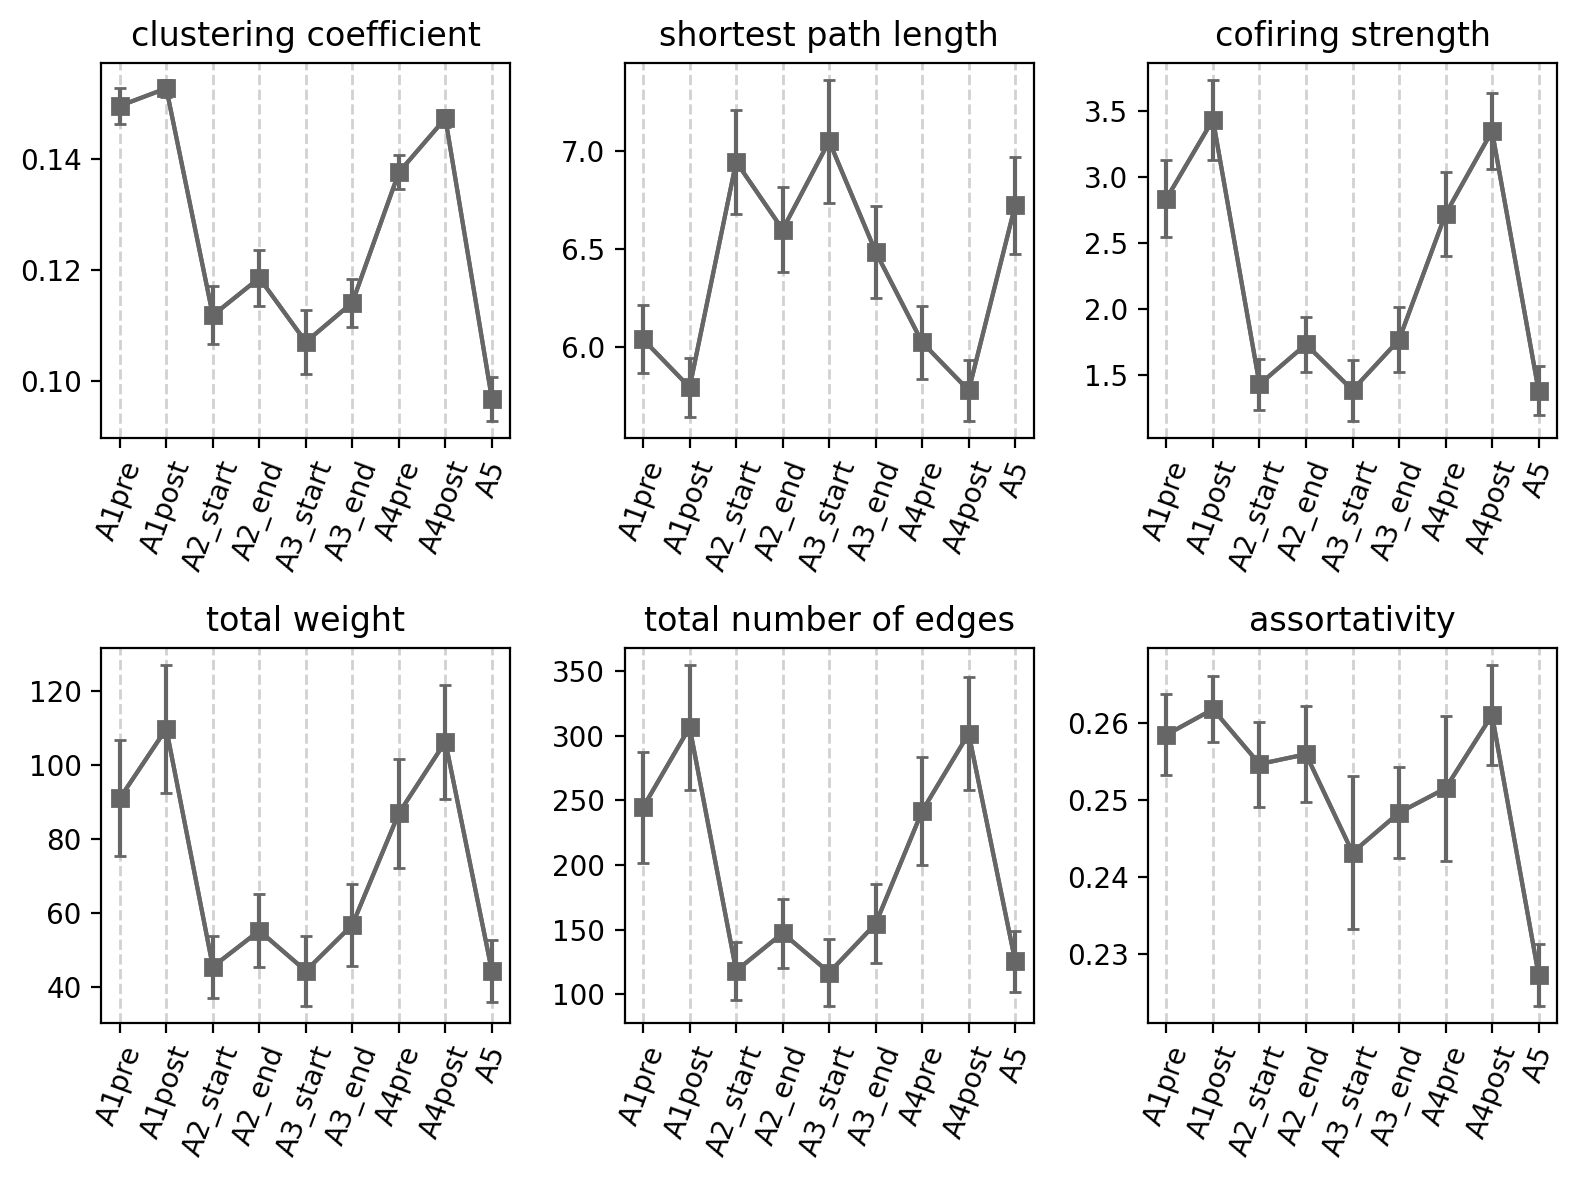

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1pre', 'A1post', 'A2_start', 'A2_end', 'A3_start', 'A3_end', 'A4pre', 'A4post', 'A5']
a = [1, 2, 3, 6, 7, 8, 9]
summary_df = df.iloc[a, 0:54]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('total weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('total number of edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

In [8]:
df.iloc[:, 24:30]

context                    A3_start                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.045905             6.763859           0.248356   
ID181106CreB               0.116506             7.574381           1.140133   
ID181106CreC               0.135212             5.872037           2.648189   
ID181106CreG               0.098939             6.587165           1.430915   
ID181106CreH               0.055880             8.250179           0.354420   
ID181106CreI               0.048942             7.259224           0.231631   
ID181106CreK               0.100584             7.631618           0.964261   
ID181106CreL               0.097446             6.813801           1.276284   
ID181106CreN               0.089927             8.315998           0.759934   
ID181106CreQ               0.110883             6.554828           1.492886   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA     6.208909                 14.35           NaN  
ID181106CreB    25.082929                 65.03      0.210069  
ID181106CreC    90.038440                244.53      0.258772  
ID181106CreG    47.935651                130.95      0.265791  
ID181106CreH    10.100967                 23.34      0.233091  
ID181106CreI     3.358649                  9.00           NaN  
ID181106CreK    23.624391                 62.25      0.226425  
ID181106CreL    43.393644                116.56      0.224616  
ID181106CreN    20.518211                 50.70      0.233579  
ID181106CreQ    59.715421                148.25      0.283120

In [9]:
df.iloc[:, 30:36]

context                      A3_end                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.076704             8.294336           0.570398   
ID181106CreB               0.119503             7.102489           1.331150   
ID181106CreC               0.137163             5.722181           2.993746   
ID181106CreG               0.105655             6.248615           1.700558   
ID181106CreH               0.080352             7.401771           0.815103   
ID181106CreI               0.083728             8.454735           0.498647   
ID181106CreK               0.107368             7.275601           1.197943   
ID181106CreL               0.105800             6.220833           1.696538   
ID181106CreN               0.107835             6.970523           1.216332   
ID181106CreQ               0.115753             5.860234           2.239281   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA    14.259952                 37.19      0.232259  
ID181106CreB    29.285304                 80.82      0.223223  
ID181106CreC   101.787375                281.52      0.246056  
ID181106CreG    56.968702                159.14      0.250388  
ID181106CreH    23.230438                 62.66      0.227812  
ID181106CreI     7.230377                 20.08      0.103803  
ID181106CreK    29.349599                 79.26      0.237192  
ID181106CreL    57.682297                157.15      0.259306  
ID181106CreN    32.840972                 85.36      0.250326  
ID181106CreQ    89.571248                239.57      0.272135

In [10]:
df.iloc[:, 18:24]

context                      A2_end                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.070272             8.487264           0.538983   
ID181106CreB               0.129918             7.032839           1.537193   
ID181106CreC               0.143108             5.882165           2.748271   
ID181106CreG               0.104104             6.341077           1.594561   
ID181106CreH               0.087894             7.696777           0.815903   
ID181106CreI               0.071004             8.490682           0.434287   
ID181106CreK               0.109424             7.298694           1.197988   
ID181106CreL               0.111515             6.520242           1.558248   
ID181106CreN               0.117143             7.152573           1.280983   
ID181106CreQ               0.114904             5.970851           2.218587   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA    13.474563                 36.54      0.169865  
ID181106CreB    33.818237                 91.75      0.223676  
ID181106CreC    93.441223                247.13      0.277053  
ID181106CreG    53.417794                146.09      0.258964  
ID181106CreH    23.253238                 60.03      0.261843  
ID181106CreI     6.297164                 17.86      0.081706  
ID181106CreK    29.350712                 78.50      0.250981  
ID181106CreL    52.980438                139.40      0.254738  
ID181106CreN    34.586543                 88.96      0.260461  
ID181106CreQ    88.743497                239.96      0.265925

In [11]:
df.iloc[:, 12:18]

context                    A2_start                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.058262             8.100153           0.321556   
ID181106CreB               0.124159             7.595604           1.217355   
ID181106CreC               0.136974             5.934264           2.492189   
ID181106CreG               0.100508             6.461253           1.445724   
ID181106CreH               0.070168             8.134542           0.453629   
ID181106CreI               0.043874             6.450856           0.217986   
ID181106CreK               0.105167             7.807665           0.962970   
ID181106CreL               0.098954             6.746459           1.293175   
ID181106CreN               0.106349             7.536241           1.035905   
ID181106CreQ               0.110950             6.532072           1.569202   

context                                                        
feature      total weight total number of edges assortativity  
ID181106CreA     8.038900                 19.20      0.230297  
ID181106CreB    26.781814                 68.64      0.266600  
ID181106CreC    84.734416                223.61      0.257265  
ID181106CreG    48.431768                132.22      0.229954  
ID181106CreH    12.928423                 28.33      0.272653  
ID181106CreI     3.160790                  8.22           NaN  
ID181106CreK    23.592761                 59.96      0.250676  
ID181106CreL    43.967960                116.55      0.245454  
ID181106CreN    27.969448                 69.47      0.257990  
ID181106CreQ    62.768096                157.41      0.274937

In [12]:
df.iloc[:, 20:].mean()

context   feature               
A2_end    co-firing strength          1.392500
          total weight               42.936341
          total number of edges     114.622000
          assortativity               0.230521
A3_start  clustering coefficient      0.090023
                                       ...    
A4_3      shortest path length        5.533158
          co-firing strength          5.002702
          total weight              150.539874
          total number of edges     432.400000
          assortativity               0.303299
Length: 70, dtype: float64

/tmp/ipykernel_882/3719985091.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/3719985091.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/3719985091.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/3719985091.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/3719985091.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
/tmp/ipykernel_882/3719985091.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


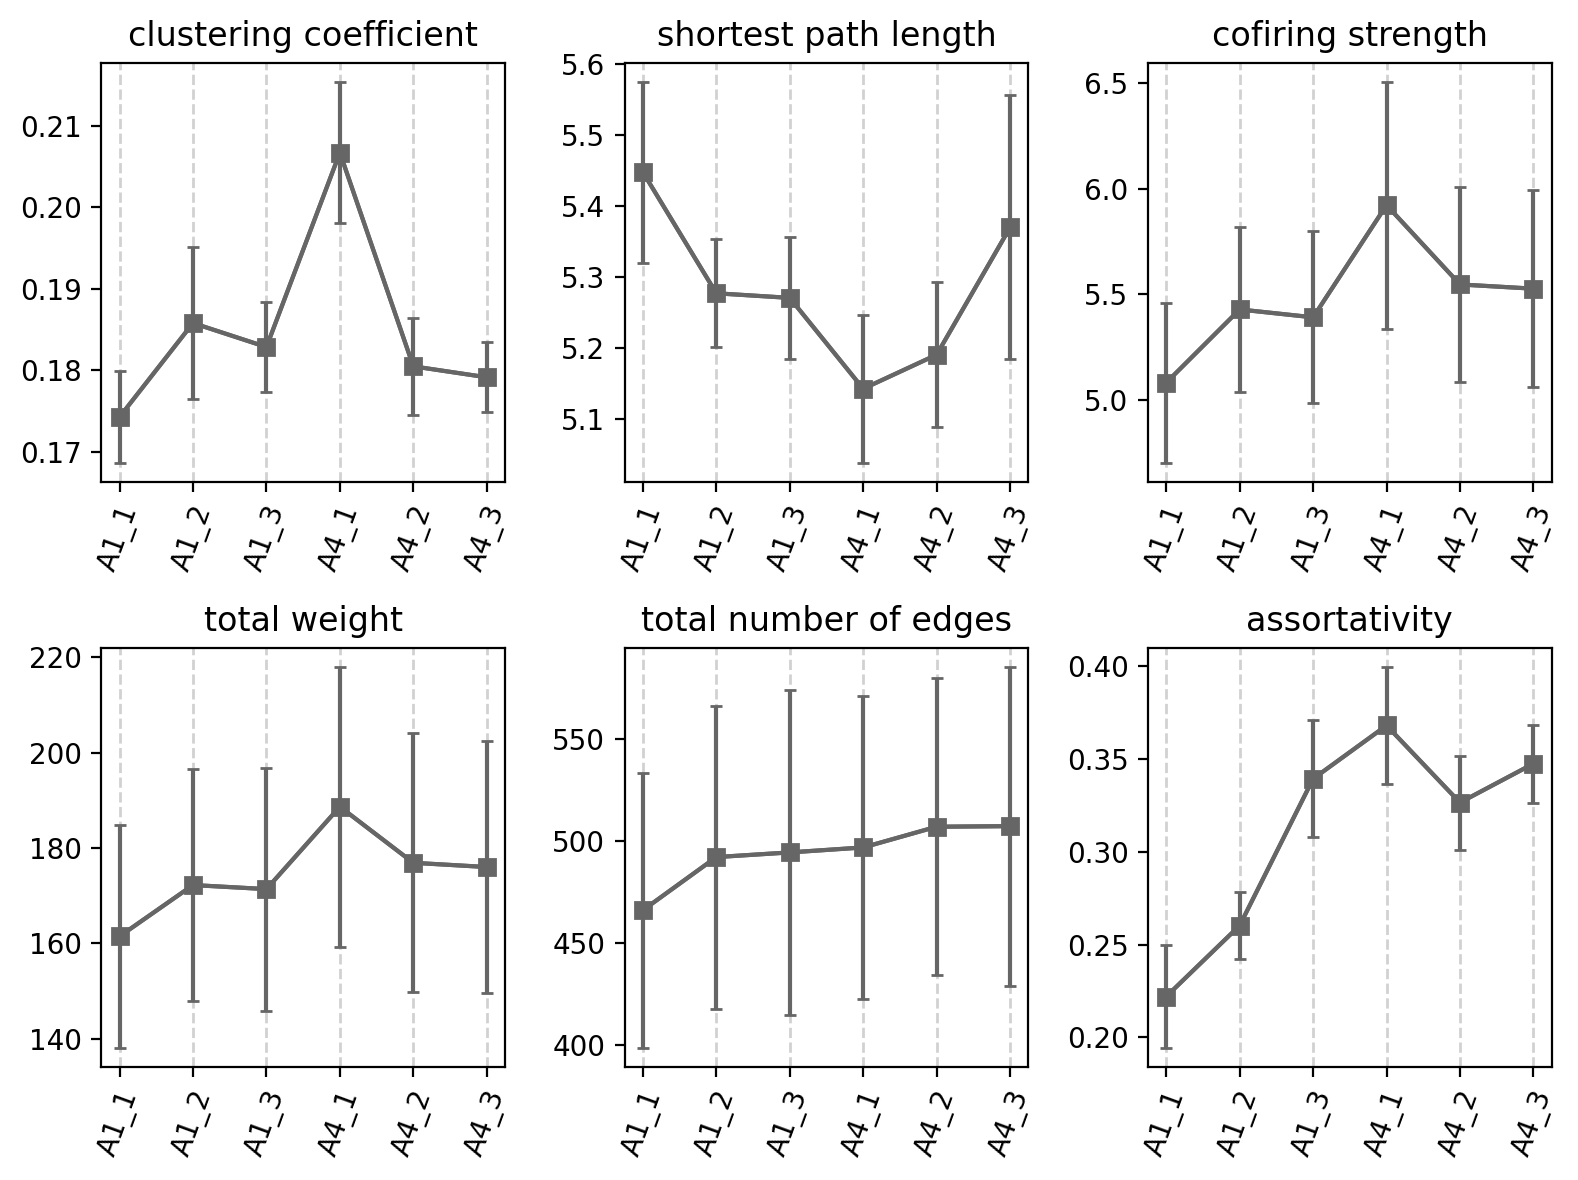

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
a = [1, 2, 3, 6, 7, 8, 9]
summary_df = df.iloc[a, 54:]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('total weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('total number of edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

/tmp/ipykernel_882/2403395848.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=45)
/tmp/ipykernel_882/2403395848.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=45)
/tmp/ipykernel_882/2403395848.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=45)
/tmp/ipykernel_882/2403395848.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=45)
/tmp/ipykernel_882/2403395848.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=45)
/tmp/ipykernel_882/2403395848.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=45)
/tmp/ipykernel_882/2403395848.py:63: UserWarning: FixedFor

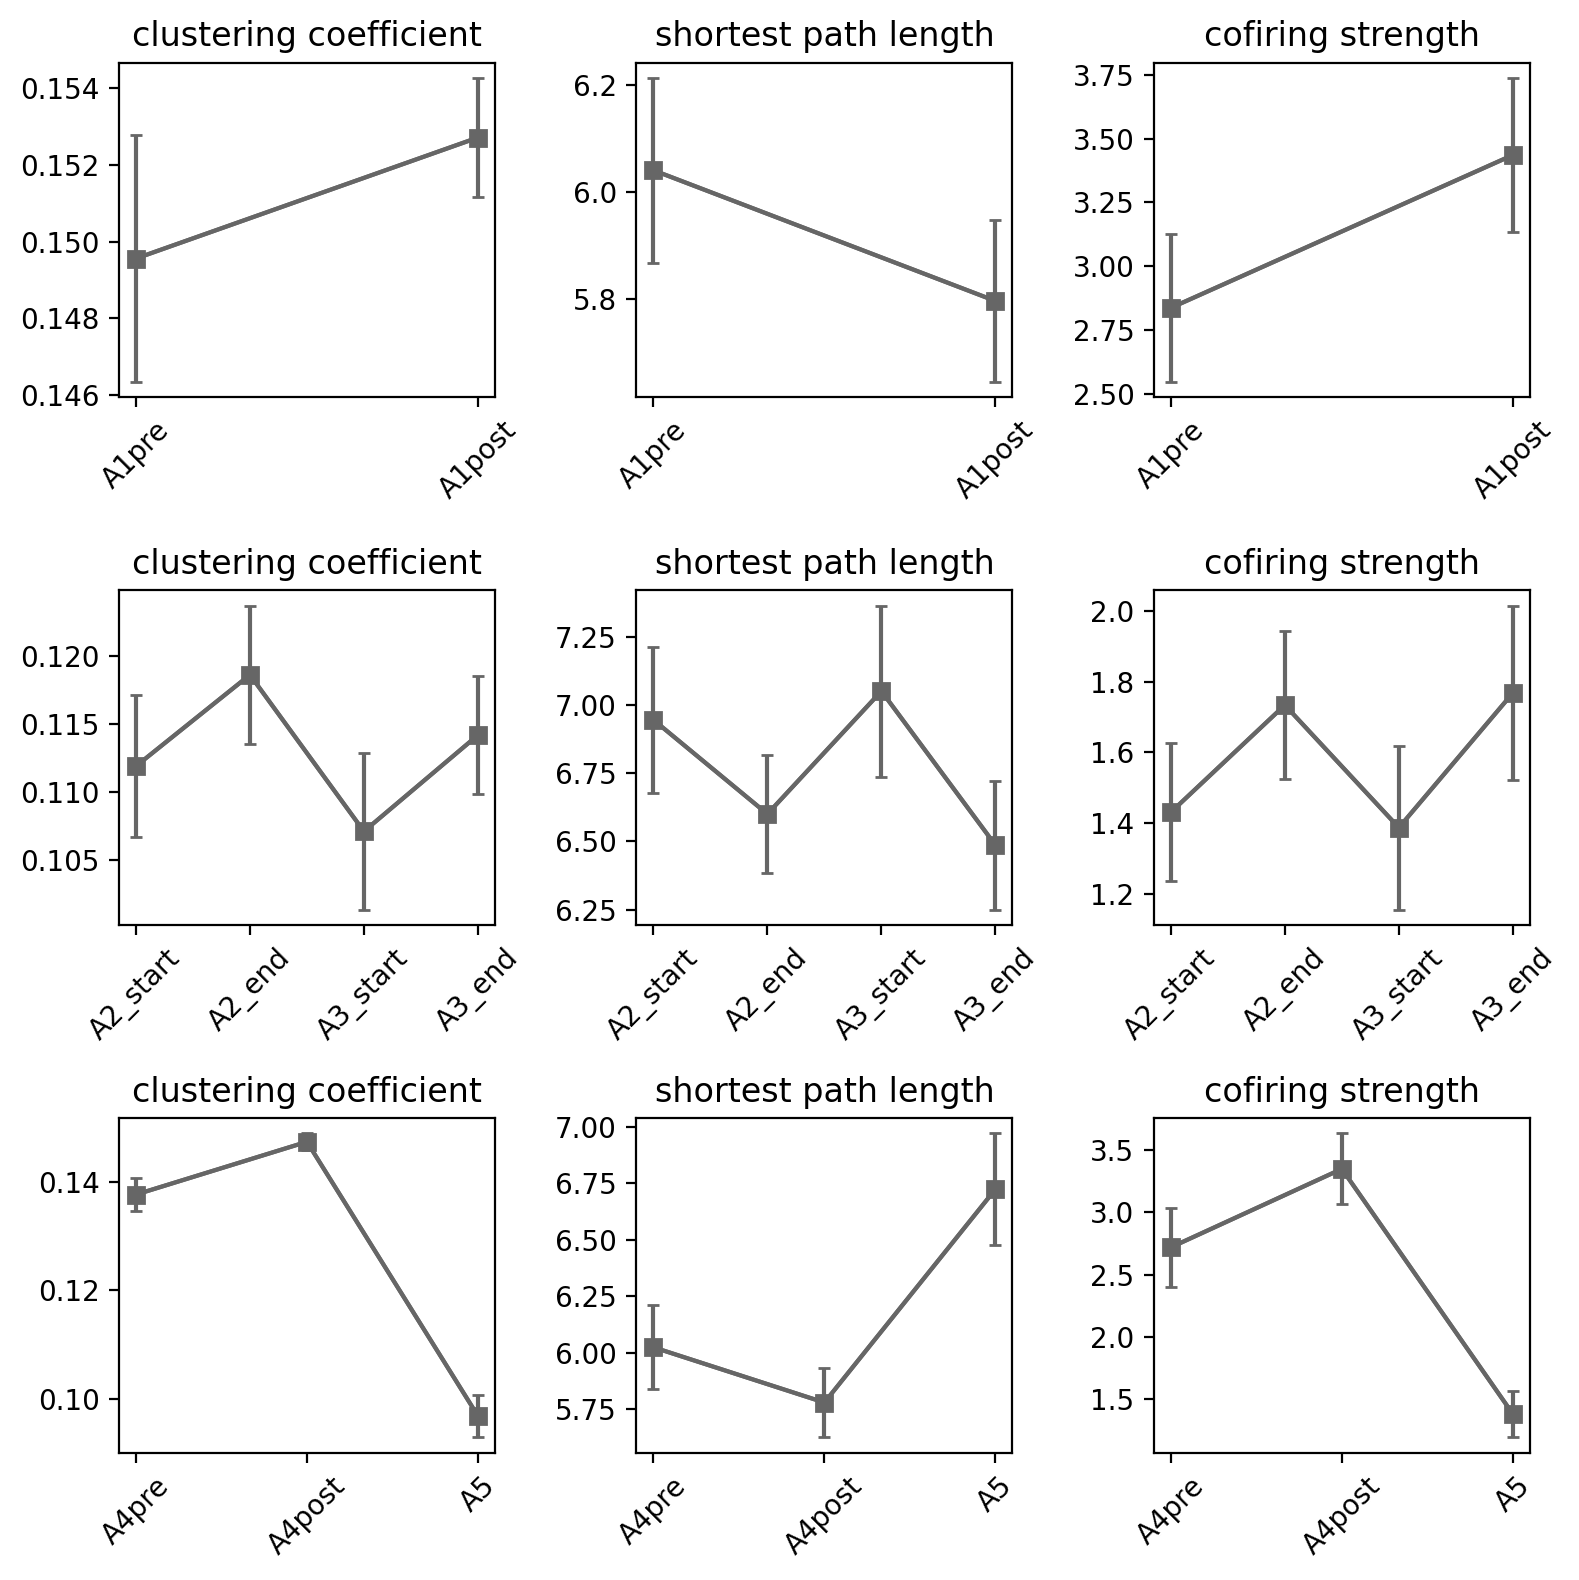

In [14]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(8, 8), tight_layout=True, dpi=200)

a = [1, 2, 3, 6, 7, 8, 9]

# A1
x = ['A1pre', 'A1post']
summary_df = df.iloc[a, 0:12]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=45)

# A2, A3

x = ['A2_start', 'A2_end', 'A3_start', 'A3_end']
summary_df = df.iloc[a, 12:36]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[1][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[1][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('clustering coefficient')
axes[1][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[1][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[1][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('shortest path length')
axes[1][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[1][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[1][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('cofiring strength')
axes[1][2].set_xticklabels(x, rotation=45)

# A4, A5

x = ['A4pre', 'A4post', 'A5']
summary_df = df.iloc[a, 36:54]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[2][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[2][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[2][0].set_title('clustering coefficient')
axes[2][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[2][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[2][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[2][1].set_title('shortest path length')
axes[2][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[2][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[2][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[2][2].set_title('cofiring strength')
axes[2][2].set_xticklabels(x, rotation=45)

fig.show()